# Imports and settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import pymc3 as pm
from scipy.stats import norm, gaussian_kde, binom, uniform
import seaborn as sns
from theano import tensor as tt

from data_generators import (
    generate_smoothly_transformed_dataset,
    generate_smoothly_transformed_datasets,
    generate_scaled_then_shifted_dataset,
    generate_scaled_then_shifted_datasets,
    generate_mixture_of_scaled_dataset,
    generate_mixture_of_scaled_datasets,
)

%matplotlib inline

In [3]:
pd.set_option('mode.chained_assignment', None)

# Overview

Our goal is to estimate the underlying mean CLTV of loans generated by a specific treatment or branch as accurately as possible. We aim to do this by updating our prior belief over the possible values this "population mean CLTV" could take with data from a sample of observed values. This sample is likely to be small, possibly very small, and we assume that the shape of the underlying distribution of CLTVs will not be well approximated by standard distributions such as the normal or gamma family.

For samples of CLTV with a large sample size (N -> ∞), the Central Limit Theorem holds that the distribution of sample means will tend toward a normal distribution, even if the original CLTV values themselves are not normally distributed (assuming finite variance, which we can safely do with CLTV). By symmetry we can infer that given a large enough sample, the pdf of the underlying population mean will be normally distributed about the sample mean with known variance, even for arbitrarily weird distributions (assuming finite variance). Likelihood estimation on sample data using a normal parameterisation will yield MLE parameters corresponding to this distribution of the population mean **[my assertion based on experiment]**, and is a therefore a suitable approach for large N (if overcomplicated, given that we can trivially compute the sample mean and variance and subsequently derive the distribution of the population mean).

However for many of the tests we run, we are unlikely to have sufficient N for this to hold.

This notebook aims to investigate whether there are more accurate approaches/estimators of the population mean for small sample size N, and if so how does the benefit of these approaches vary (in terms of the relative E[absolute error] of the estimators) as N is varied.


# A generative distribution derived from empirical CLTV data

The empirical distribution of CLTV can be derived from observed data. In this notebook, a distribution built from a sample of 388 loan CLTVs is used as a reference distribution. This distribution was built in a separate [notebook](empirical_distribution.ipynb). By using domain knowledge to reason about how this CLTV distribution may be altered when we make product changes, we aim to build parameterisations that can transform this distribution and hope that these transformed custom distributions will more accurately model the true distribution of CLTV under the influence of  product changes (compared to using standard parametric models such as the gaussian or gamma family).

We will test whether learning posterior distributions over the parameters described above allows us to estimate the population mean CLTV more accurately for small sample sizes.

A number of parameterisations are formulated below. For each of these parameterisations we generate datasets for a range of parameter values. We also generate datasets using different generative models such as mixtures. For each parameterisation, we then test the ability of an estimator that assumes the parameterisation as its generative model to learn the correct underlying CLTV for all datasets (i.e. both those generated with the corresponding generative model and those generated with other models). We expect the estimators to outperform an estimator that assumes a normal distribution as its generative model on their own "home" datasets.

## The reference distribution

In [4]:
reference_data = pd.read_csv('reference_data_for_empirical_dist.csv')
empirical_n_loans = len(reference_data)
empirical_cltvs = reference_data['cltv_total_initial']

In [5]:
with open('reference_distribution.pkl', 'rb') as filepath:
    reference_distribution = pickle.load(filepath)

In [6]:
cltv_grid = np.linspace(reference_distribution.x_points.min(), reference_distribution.x_points.max(), 100000)
pdf_grid = np.exp(reference_distribution.logp(cltv_grid).eval())
reference_distribution_mean = (pdf_grid * cltv_grid).sum() / pdf_grid.sum()
reference_distribution_std = ((pdf_grid * (cltv_grid - reference_distribution_mean)**2).sum() / pdf_grid.sum()) ** 0.5
print(f'''
Reference distribution loaded.
Mean CLTV: £{reference_distribution_mean:,.2f}
Std: £{reference_distribution_std:,.2f}
''')


Reference distribution loaded.
Mean CLTV: £15,419.05
Std: £15,917.40



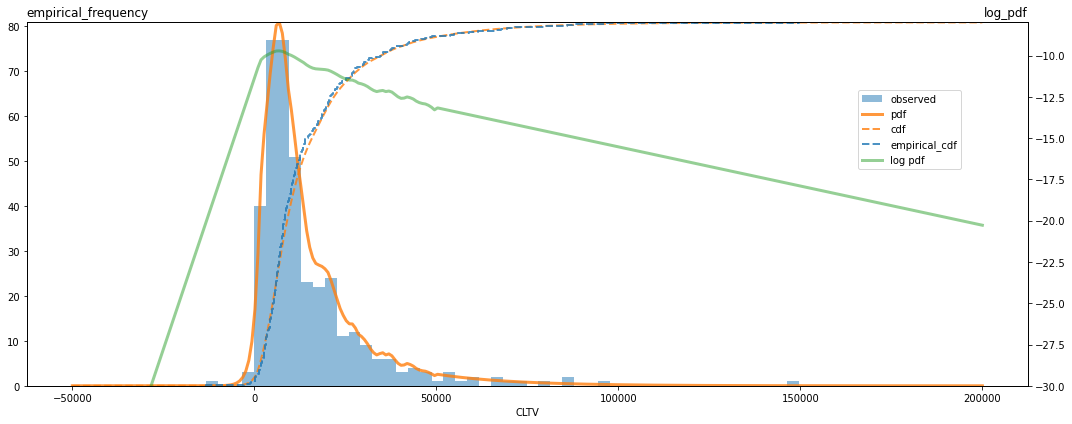

In [7]:
x = np.linspace(-50000, 200000, 300)
y_pdf = np.exp(reference_distribution.logp(x).eval())
y_pdf /= max(y_pdf)
y_cdf = np.cumsum(y_pdf) / sum(y_pdf)
y_log = reference_distribution.logp(x).eval()

fig, ax = plt.subplots(figsize=(15,6))
ax2 = ax.twinx()
ax3 = ax.twinx()
ax.hist(empirical_cltvs, bins=50, alpha=0.5, label='observed')
ax2.plot(x, y_pdf, alpha=0.8, lw=3, color='C1', label='pdf')
ax2.plot(x, y_cdf, alpha=0.8, lw=2, color='C1', ls='--', label='cdf')
ax3.plot(x, y_log, alpha=0.5, lw=3, color='C2', label='log pdf')
ax3.set_ylim(bottom = -30)
ax.set_title('empirical_frequency', loc='left')
ax3.set_title('log_pdf', loc='right')
ax2.tick_params(right=False, labelright=False)
sns.ecdfplot(data=empirical_cltvs, ax=ax2, ls='--', lw=2, alpha=0.8, label='empirical_cdf')
fig.legend(loc=(0.8, 0.6))
ax.set_xlabel('CLTV')
plt.tight_layout();

### Generating data from the reference distribution

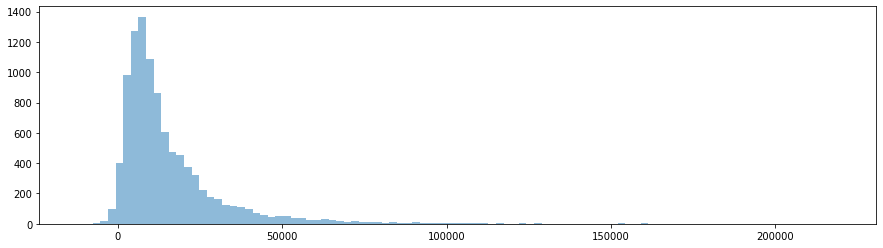

In [8]:
fig, ax = plt.subplots(figsize=(15,4))
ax.hist(reference_distribution.random(size=10000), bins=100, alpha=0.5);

## Transformations of the reference distribution

Four ways to transform the pdf of the reference distribution are outlined below, with example datasets generated to illustrate the effect these transformations have.

### Multiplicative scaling

Muliplicative scaling of the reference pdf along the CLTV axis, taking one scale parameter:

$$ p(CLTV)_{trans} \propto p(\frac{CLTV}{scale})_{ref}$$

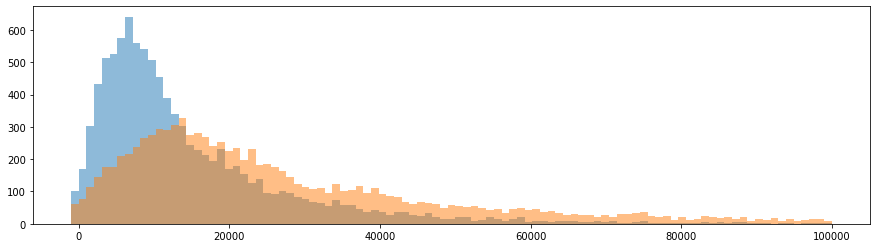

In [9]:
fig, ax = plt.subplots(figsize=(15,4))
ref_dist = reference_distribution.random(size=10000)
scaled = generate_scaled_then_shifted_dataset(
    reference_distribution,
    scale=2.0,
    loc=0.0,
    size=10000,
    ref_mean=reference_distribution_mean
)[0]

bins = np.linspace(-1000, 100000, 100)
ax.hist(ref_dist, bins=bins, alpha=0.5)
ax.hist(scaled, bins=bins, alpha=0.5);

### Scale then shift

Scaling then shifting the reference pdf (effectively an extension of 1. that allows for a `loc` parameter in addition to `scale`):

$$ p(CLTV)_{trans} \propto p(\frac{CLTV-loc}{scale})_{ref}$$

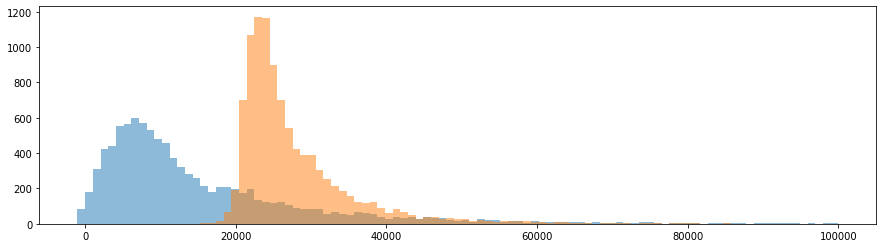

In [10]:
fig, ax = plt.subplots(figsize=(15,4))
ref_dist = reference_distribution.random(size=10000)
scaled_then_shifted = generate_scaled_then_shifted_dataset(
    reference_distribution,
    scale=0.5,
    loc=20000.0,
    size=10000,
    ref_mean=reference_distribution_mean
)[0]


bins = np.linspace(-1000, 100000, 100)
ax.hist(ref_dist, bins=bins, alpha=0.5)
ax.hist(scaled_then_shifted, bins=bins, alpha=0.5);

### Smooth transformation

A "smooth" exponential transform of the reference pdf, parameterised by a single `tau` parameter:

$$ p(CLTV)_{trans} \propto e^{\tau . CLTV} p(CLTV)_{ref}$$

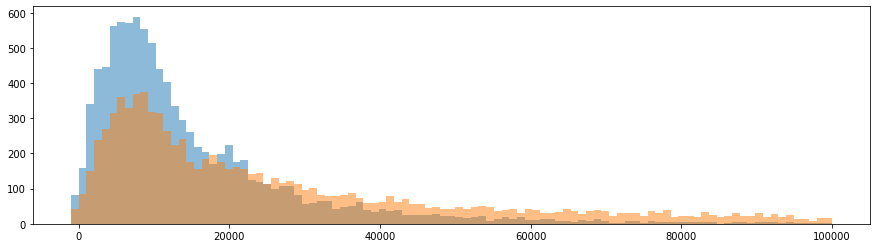

In [11]:
fig, ax = plt.subplots(figsize=(15,4))
ref_dist = reference_distribution.random(size=10000)
smoothly_transformed = generate_smoothly_transformed_dataset(
    cltv_grid,
    pdf_grid,
    tau=3e-5,
    size=10000,
)[0]


bins = np.linspace(-1000, 100000, 100)
ax.hist(ref_dist, bins=bins, alpha=0.5)
ax.hist(smoothly_transformed, bins=bins, alpha=0.5);

### Mixture of scaled distributions

A mixture of two distributions that are scaled versions of the reference distribution:

$$ p(CLTV)_{trans} \ \propto \  mix1 \cdot p(\frac{CLTV}{scale1})_{ref} \ + \ (1-mix1) \cdot p(\frac{CLTV}{scale2})_{ref}$$

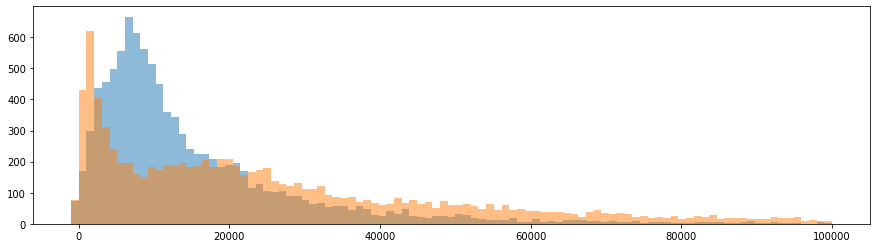

In [12]:
fig, ax = plt.subplots(figsize=(15,4))
ref_dist = reference_distribution.random(size=10000)
mixture = generate_mixture_of_scaled_dataset(
    reference_distribution,
    mix1_scale=0.2,
    mix2_scale=2.5,
    mix1_proportion=0.2,
    size=10000,
    ref_mean=reference_distribution_mean
)[0]


bins = np.linspace(-1000, 100000, 100)
ax.hist(ref_dist, bins=bins, alpha=0.5)
ax.hist(mixture, bins=bins, alpha=0.5);

# The Bayesian approach to parameter estimation

Bayesian estimation of expected CLTV first requires that we parameterise the distribution of CLTVs. We then need to provide prior probability distributions over the relevant parameters as well as a way to compute the likelihood of observed data given the model and the parameters. This should allow us to derive a posterior probability distribution over the model parameters. As long as we can map parameter values to an expected CLTV for the distribution they describe, we can then sample parameter values from our posterior distribution and average over the resultant CLTVs to obtain an overall expected CLTV given our prior and the observed data.

We tried two ways to implement this process:
 1. Using pymc3 to define continuous priors and to sample from the posterior in continous parameter space
 2. Defining priors and calculating posteriors only at discrete points on a grid in parameter space

#### pymc3
 - pymc3 is *much* slower but does a lot of things automatically including sampling from a continuous, multi-dimensional and potentially infinite parameter space
 - Supplying non-standard priors and likelihood functions is tricky but not impossible
 - The slowness means that it is hard to get statistical levels of data out of pymc3, however it would be preferable for real applications where we just need one estimate

#### Grid approach
 - [I think] the grid approach works for 1- or 2- dimensional parameter spaces but would struggle beyond this
 - It is much quicker than pymc3 for grids of around 40,000 points and can therefore be used to generate statistical levels of data for these purposes
 - The grid approach allows complicated priors and likelihoods to be defined easily

The rest of this notebook uses the grid approach.

# Model selection

The three custom parameterisations we are going to test are:
 1. Muliplicative scaling of the reference pdf along the CLTV axis, taking one `scale` parameter
 2. Scaling then shifting the reference pdf (effectively an extension of 1. that allows for a `loc` parameter in addition to `scale`)
 3. A "smooth" exponential transform of the reference pdf, parameterised by a single `tau` parameter:

$$ p(CLTV)_{trans} \propto e^{\tau . CLTV} p(CLTV)_{ref}$$

These will be tested against an estimator which assumes a generative model with a normal pdf for CLTV (taking two parameters, `mu` and `sigma`)

# Defining priors

Our objective is to assess the relative performance of various estimators (of population mean CLTV) given observed data. We want to isolate the effect of varying these models - defined by their likelihood functions - from any other source of variation in performance, such as differences in the prior. We therefore need to take care to encode priors for the different parameterisations that are as similar as possible in the output space - in this case the distribution they imply over CLTV.

I have chosen to construct priors for each parameterisation that imply a uniform probability over population mean CLTV between certain bounds. This will trivially correspond to a uniform prior over the mean of a normal distribution between these bounds.

## Helper functions (possibly remove these to a .py file?)

In [13]:
def get_k_from_tau(tau):
    tau_grid = pdf_grid * np.exp(cltv_grid * tau)
    k = pdf_grid.sum() / tau_grid.sum()
    return k

def get_k_grid_from_tau_grid(tau_grid):
    tau_shape = tau_grid.shape
    tau_ravel = tau_grid.ravel()
    k_ravel = np.array([get_k_from_tau(tau) for tau in tau_ravel])
    return k_ravel.reshape(tau_shape)

def get_cltv_from_tau(tau):
    tau_grid = pdf_grid * np.exp(cltv_grid * tau)
    k = pdf_grid.sum() / tau_grid.sum()
    cltv_ratio = (k * tau_grid * cltv_grid).sum() / (pdf_grid * cltv_grid).sum()
    return cltv_ratio

def get_cltv_ratios_from_scale_then_shift(scales, locs):
    return ((reference_distribution_mean * scales) + locs) / reference_distribution_mean

def get_cltv_ratios_from_smooth_transform(taus):
    taus_shape = taus.shape
    taus_ravel = taus.ravel()
    cltv_ratio_ravel = np.array([get_cltv_from_tau(tau) for tau in taus_ravel])
    return cltv_ratio_ravel.reshape(taus_shape)

def get_cltv_ratios_from_normal(mus):
    return mus / reference_distribution_mean

## Construct uniform priors in CLTV space
These are constructed such that every point on the grid has equal prior probability. This means that the likelihood function will effectively be equal to the posterior.

In [14]:
lower_bound = 0.5
upper_bound = 2.0
resolution = 10000

In [15]:
cltv_effect_prior = np.linspace(lower_bound, upper_bound, resolution)

# multiplicative scale
scale_multiplier_prior = cltv_effect_prior

# scale then shift
# my approach is to randomly perturb the contribution from the scale parameter around the required total effect,
# then to make up the difference using the loc parameter
# NB - I go in and out of log space here as I don't want to "flip" the distribution with a negative scale factor
log_cltv_effect = np.log(cltv_effect_prior)
log_scale_component = norm.rvs(log_cltv_effect, np.log(2.0))
sts_scale_prior = np.exp(log_scale_component)
sts_loc_prior = (cltv_effect_prior - sts_scale_prior) * reference_distribution_mean

# smooth transform
# I use np.interp to approximate the tau required to hit regularly spaced CLTV factors
tau_orig = np.linspace(-0.0005, 0.00003, 10000) 
cltvs_orig = get_cltv_ratios_from_smooth_transform(tau_orig).ravel() 
cltvs_orig.min(), cltvs_orig.max() # resultant CLTV ranges from -0.14 to 2.55
smt_tau_prior = np.interp(cltv_effect_prior, cltvs_orig, tau_orig)
smt_k_prior = get_k_grid_from_tau_grid(smt_tau_prior)

# normal - I am going to fix std at the reference distribution std as it has no effect on the mean CLTV learned
# it would affect the width of the posterior, but that isn't what we care about here
normal_mu_prior = cltv_effect_prior * reference_distribution_mean

# Likelihood functions

In [16]:
quick_kde_eval_points = np.linspace(reference_distribution.x_points.min(),
                                    reference_distribution.x_points.max(),
                                    100000)

quick_kde_log_pdf_points = reference_distribution.logp(quick_kde_eval_points).eval()
    
def quick_kde(cltvs):    
    return np.interp(cltvs, quick_kde_eval_points, quick_kde_log_pdf_points)

In [17]:
def log_likelihood_sts(observed_values, scale_grid, shift_grid):
    evaluation_points = (np.subtract.outer(observed_values, shift_grid) / scale_grid)
    return (quick_kde(evaluation_points) - np.log(scale_grid)).sum(axis=0)

def log_likelihood_smt(observed_values, tau_grid, k_grid):
    assert tau_grid.shape == k_grid.shape
    return (
        quick_kde(observed_values).reshape(-1,1)
        + np.multiply.outer(observed_values, tau_grid)
        + np.log(k_grid)
    ).sum(axis=0)

def log_likelihood_nrm(observed_values, mu_grid, std):
    obs_reshaper = (-1, *np.ones_like(mu_grid.shape))
    return norm.logpdf(observed_values.reshape(*obs_reshaper),
                       mu_grid,
                       std).sum(axis=0)

# Posterior calculation

In [18]:
def get_stats_from_loglike(loglike, effective_cltvs, underlying_ratio):
    loglike = loglike - loglike.max()
    pdf = np.exp(loglike).ravel()
    pdf /= pdf.sum()
    e_cltv = (pdf * effective_cltvs).sum()
    true_percentile = sum([x[1] for x in zip(effective_cltvs, pdf) if x[0] < underlying_ratio])
    return e_cltv, true_percentile

In [19]:
def get_posterior_stats(observed_data, mults, scales, locs, taus, ks, mus, effective_cltvs, underlying_ratio):
    loglike_mul = log_likelihood_sts(observed_data, mults, np.zeros_like(mults))
    loglike_sts = log_likelihood_sts(observed_data, scales, locs)
    loglike_smt = log_likelihood_smt(observed_data, taus, ks)
    loglike_nrm = log_likelihood_nrm(observed_data, mus, reference_distribution_std)
    e_cltv_mul, percentile_mul = get_stats_from_loglike(loglike_mul, effective_cltvs, underlying_ratio)
    e_cltv_sts, percentile_sts = get_stats_from_loglike(loglike_sts, effective_cltvs, underlying_ratio)
    e_cltv_smt, percentile_smt = get_stats_from_loglike(loglike_smt, effective_cltvs, underlying_ratio)
    e_cltv_nrm, percentile_nrm = get_stats_from_loglike(loglike_nrm, effective_cltvs, underlying_ratio)
    return {
        'e_cltv_mul': e_cltv_mul,
        'e_cltv_sts': e_cltv_sts,
        'e_cltv_smt': e_cltv_smt,
        'e_cltv_nrm': e_cltv_nrm,
        'percentile_mul': percentile_mul,
        'percentile_sts': percentile_sts,
        'percentile_smt': percentile_smt,
        'percentile_nrm': percentile_nrm,
        'underlying_ratio': underlying_ratio,
        'sample_ratio': observed_data.mean() / reference_distribution_mean
    }

# Generate test datasets

In [20]:
generate_datasets = False

if generate_datasets:
    my_datasets = []
    for sz, n in [(1, 3000), (3, 3000), (10, 3000), (30, 3000), (100, 1000), (300, 300), (1000, 100)]:
        my_datasets.extend([('mul', sz, *t) for t in
                            generate_scaled_then_shifted_datasets(reference_distribution,
                                                                  scales=norm.rvs(1.0, 0.3, n),
                                                                  locs=np.zeros(n),
                                                                  size=sz,
                                                                  ref_mean=reference_distribution_mean)])
        my_datasets.extend([('sts', sz, *t) for t in
                            generate_scaled_then_shifted_datasets(reference_distribution,
                                                                  scales=norm.rvs(1.0, 0.2, n),
                                                                  locs=norm.rvs(0.0, 3000., n),
                                                                  size=sz,
                                                                  ref_mean=reference_distribution_mean)])
        my_datasets.extend([('smt', sz, *t) for t in
                            generate_smoothly_transformed_datasets(cltv_grid,
                                                                   pdf_grid,
                                                                   taus=np.random.choice(smt_tau_prior, size=n),
                                                                   size=sz)])
        my_datasets.extend([('mix', sz, *t) for t in
                            generate_mixture_of_scaled_datasets(reference_distribution,
                                                                mix1_scales=norm.rvs(1.0, 0.3, n),
                                                                mix2_scales=norm.rvs(1.0, 0.3, n),
                                                                mix1_proportions=uniform.rvs(size=n),
                                                                size=sz,
                                                                ref_mean=reference_distribution_mean)])

In [21]:
# len(my_datasets)

# Do experiment

In [22]:
do_experiment = False

if do_experiment:
    results = []
    for i, d in enumerate(my_datasets):
        if i % 1000 == 0:
            print('.', end='')
        results.append({
            'generative_model': d[0],
            'n_observations': d[1],
            **get_posterior_stats(
                d[2],
                scale_multiplier_prior,
                sts_scale_prior,
                sts_loc_prior,
                smt_tau_prior,
                smt_k_prior,
                normal_mu_prior,
                cltv_effect_prior,
                d[3]
            )
        })

In [23]:
get_df_from_pickle = True

if get_df_from_pickle:
    with open('results_df.pkl', 'rb') as filepath:
        results_df = pickle.load(filepath)
else:
    results_df = pd.DataFrame(results)
    # pn stands for parameterisation
    for pn in ['mul', 'sts', 'smt', 'nrm']:
        results_df[f'error_{pn}'] = results_df[f'e_cltv_{pn}'] - results_df['underlying_ratio']
        results_df[f'abs_error_{pn}'] = abs(results_df[f'error_{pn}'])
    results_df['abs_error_sample_mean'] = abs(results_df['sample_ratio'] - results_df['underlying_ratio'])

In [24]:
# with open('results_df.pkl', 'wb') as filepath:
#     pickle.dump(results_df, filepath)

In [25]:
stacked = results_df.groupby(['generative_model', 'n_observations'])[[
    'abs_error_mul', 'abs_error_sts', 'abs_error_smt', 'abs_error_nrm', 'abs_error_sample_mean'
]].mean().stack().reset_index().rename(columns={'level_2': 'metric', 0: 'value'})

In [26]:
# stacked.head()

In [27]:
stacked['log_n_obs'] = np.log(stacked['n_observations'])
stacked['log_mean_relative_error'] = np.log(stacked['value'])

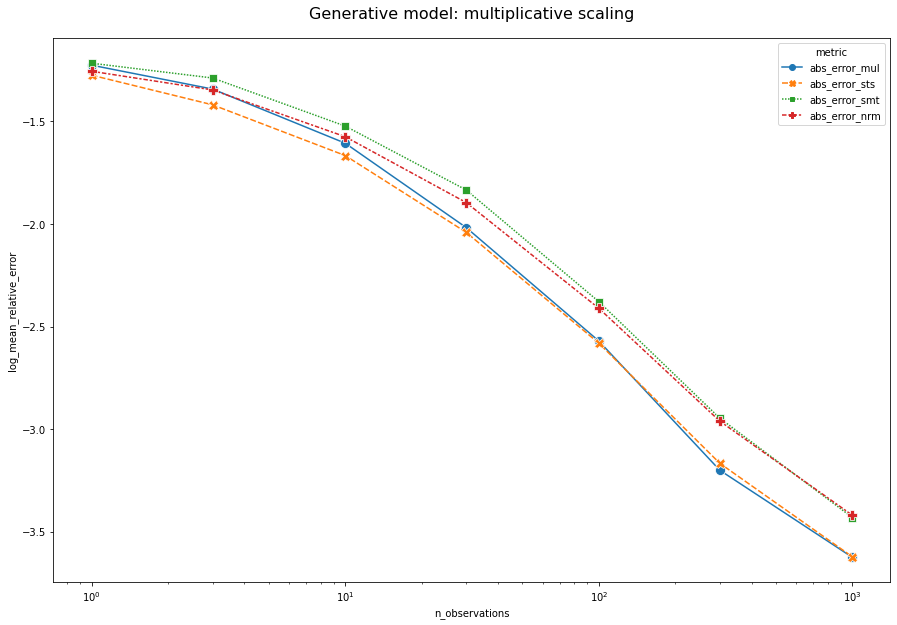

In [28]:
fig, ax = plt.subplots(figsize=(15,10))
mask = (stacked['generative_model'] == 'mul') & (stacked['metric'] != 'abs_error_sample_mean')
g = sns.lineplot(data=stacked[mask],
             x='n_observations',
             y='log_mean_relative_error',
             hue='metric',
             style='metric',
             markers=True,
             markersize=10,
             ax=ax)
ax.set_title('Generative model: multiplicative scaling', fontsize=16, pad=20)
g.set_xscale('log');

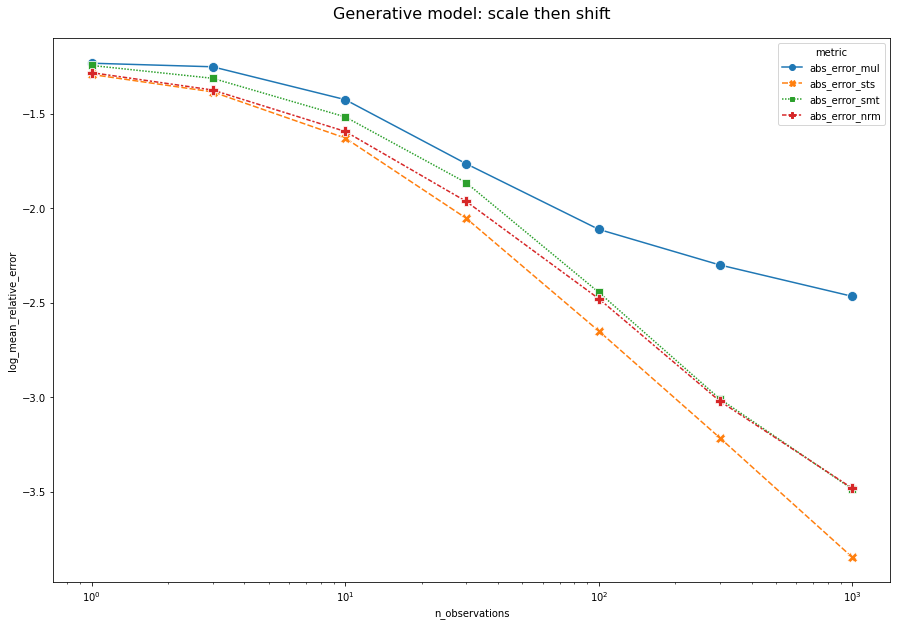

In [29]:
fig, ax = plt.subplots(figsize=(15,10))
mask = (stacked['generative_model'] == 'sts') & (stacked['metric'] != 'abs_error_sample_mean')
g = sns.lineplot(data=stacked[mask],
             x='n_observations',
             y='log_mean_relative_error',
             hue='metric',
             style='metric',
             markers=True,
             markersize=10,
             ax=ax)
ax.set_title('Generative model: scale then shift', fontsize=16, pad=20)
g.set_xscale('log');

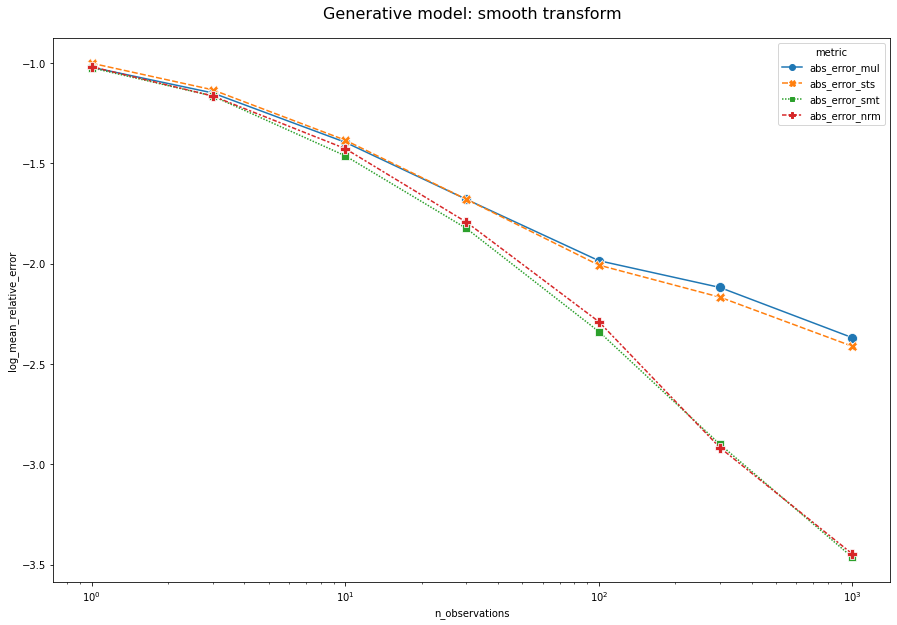

In [30]:
fig, ax = plt.subplots(figsize=(15,10))
mask = (stacked['generative_model'] == 'smt') & (stacked['metric'] != 'abs_error_sample_mean')
g = sns.lineplot(data=stacked[mask],
             x='n_observations',
             y='log_mean_relative_error',
             hue='metric',
             style='metric',
             markers=True,
             markersize=10,
             ax=ax)
ax.set_title('Generative model: smooth transform', fontsize=16, pad=20)
g.set_xscale('log');

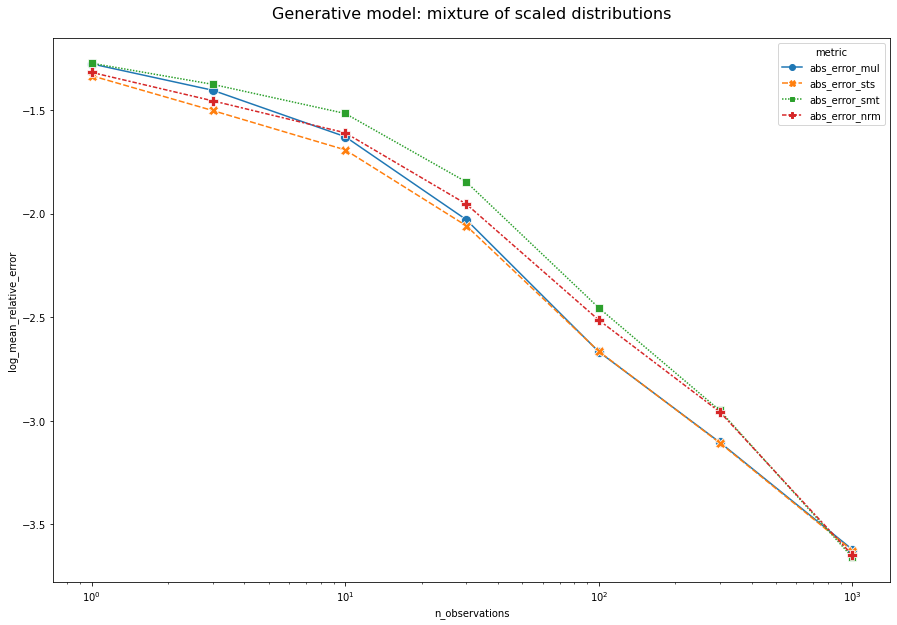

In [31]:
fig, ax = plt.subplots(figsize=(15,10))
mask = (stacked['generative_model'] == 'mix') & (stacked['metric'] != 'abs_error_sample_mean')
g = sns.lineplot(data=stacked[mask],
             x='n_observations',
             y='log_mean_relative_error',
             hue='metric',
             style='metric',
             markers=True,
             markersize=10,
             ax=ax)
ax.set_title('Generative model: mixture of scaled distributions', fontsize=16, pad=20)
g.set_xscale('log');